Setup

In [1]:
# Mount Google Drive and import libraries
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import shutil
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Mounted at /content/drive
Using device: cpu


Dataset Splitting

In [4]:
# Path to the original dataset where each class has its own folder
original_data_dir = "/content/drive/MyDrive/Kolam/kolam_dataset_all"
# Path to the output directory for the split dataset
data_dir = "/content/drive/MyDrive/Kolam/kolam_dataset_split"

# Create directories
os.makedirs(data_dir, exist_ok=True)
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Split data with an 80/20 ratio for training/validation
split_ratio = 0.8
for kolam_class in os.listdir(original_data_dir):
    class_folder = os.path.join(original_data_dir, kolam_class)
    if not os.path.isdir(class_folder):
        continue

    images = os.listdir(class_folder)
    random.shuffle(images)
    train_count = int(len(images) * split_ratio)

    os.makedirs(os.path.join(train_dir, kolam_class), exist_ok=True)
    os.makedirs(os.path.join(val_dir, kolam_class), exist_ok=True)

    for i, img_name in enumerate(images):
        src_path = os.path.join(class_folder, img_name)
        if i < train_count:
            dst_path = os.path.join(train_dir, kolam_class, img_name)
        else:
            dst_path = os.path.join(val_dir, kolam_class, img_name)
        shutil.copy(src_path, dst_path)

print("Dataset successfully split into train and validation sets.")

Dataset successfully split into train and validation sets.


Data Augmentation & DataLoader

In [5]:
# Define transformations for training and validation data
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets and dataloaders
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ["train", "val"]
}

# Get the class names
class_names = image_datasets["train"].classes
print("Detected classes:", class_names)

Detected classes: ['bird', 'dot', 'floral']


 Load Pretrained MobileNetV2

In [6]:
# Load a pretrained MobileNetV2 model
model = models.mobilenet_v2(weights="IMAGENET1K_V1")

# Replace the final classifier layer to match the number of Kolam classes (4)
num_classes = len(class_names)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 99.3MB/s]


Training Loop

In [7]:
!pip install tqdm -q
from tqdm import tqdm

def train_model(model, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        train_loader = tqdm(dataloaders["train"], desc="Training")
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            train_loader.set_postfix(loss=loss.item())
        epoch_loss = running_loss / len(image_datasets["train"])

        # --- Validation Phase ---
        model.eval()
        running_corrects = 0
        val_loader = tqdm(dataloaders["val"], desc="Validation")
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

        val_acc = running_corrects.double() / len(image_datasets["val"])
        print(f"Train Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the model if it has the best validation accuracy so far
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/content/drive/MyDrive/kolam_model_best.pth")

    print("Training Complete. Best Val Acc:", best_acc)
    return model

# Start the training process
model = train_model(model, criterion, optimizer, num_epochs=10)


Epoch 1/10


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


Train Loss: 1.0212, Val Acc: 0.7647

Epoch 2/10


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Train Loss: 0.5503, Val Acc: 0.8529

Epoch 3/10


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.93s/it]


Train Loss: 0.4161, Val Acc: 0.8529

Epoch 4/10


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Train Loss: 0.2870, Val Acc: 0.8529

Epoch 5/10


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


Train Loss: 0.2223, Val Acc: 0.8824

Epoch 6/10


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Train Loss: 0.1555, Val Acc: 0.8529

Epoch 7/10


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


Train Loss: 0.1363, Val Acc: 0.8529

Epoch 8/10


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]


Train Loss: 0.1061, Val Acc: 0.8824

Epoch 9/10


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Train Loss: 0.0654, Val Acc: 0.8824

Epoch 10/10


Validation: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it]

Train Loss: 0.0875, Val Acc: 0.8824
Training Complete. Best Val Acc: tensor(0.8824, dtype=torch.float64)


 Prediction on a Single Image

Saving Screenshot 2025-09-19 215459.png to Screenshot 2025-09-19 215459 (1).png


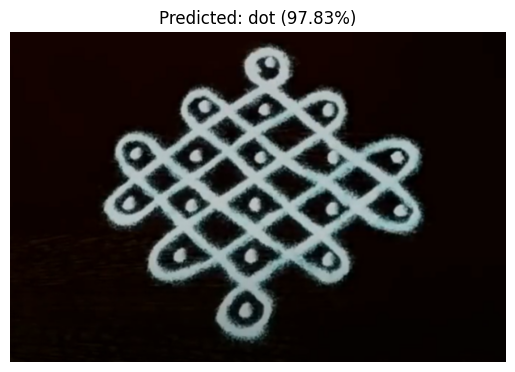

In [13]:
from google.colab import files
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Function to predict the class of a single image
def predict_kolam(image_path):
    model.eval()

    # Load and transform the image
    img = Image.open(image_path).convert("RGB")
    transform = data_transforms['val']  # Use validation transforms
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        confidence, pred_index = torch.max(probs, 1)
        predicted_class = class_names[pred_index.item()]

    return predicted_class, confidence.item(), img

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    predicted_class, confidence, img = predict_kolam(filename)

    # Display image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
    plt.show()


Export Model

In [11]:
# Load the best performing model weights before exporting
model.load_state_dict(torch.load("/content/drive/MyDrive/kolam_model_best.pth"))
model.eval()

# Save the final PyTorch model
torch.save(model.state_dict(), "/content/drive/MyDrive/kolam_model_final.pth")

# Convert to TorchScript for server deployment
example_input = torch.rand(1, 3, 224, 224).to(device)
traced_model = torch.jit.trace(model, example_input)
traced_model.save("/content/drive/MyDrive/kolam_model_server.pt")

print("Model successfully exported for API/cloud deployment.")

Model successfully exported for API/cloud deployment.
